# Computational Modeling - Lab5 - Band gap (Egap) prediction of inorganic crystalline materials

Natalie Pham

Andrew ID: thanhngp

### Summary

1. Pre-processing
- The train dataset has 9640 rows and 134 features including ID of each rows.
- Normalize the train set and test set
- Use train-test-split to split the train set into train and validation sets (with a ratio of 75:25). So 75% of the training set was selected for training and 25% was used for validation.

2. Visualize Dataset with PCA, color coded by labels

3. Quick experiment with different models
- All mean absolute errors are computed using the validation set.
- Quick experiment with linear regression, logistic regression, Ridge regression, LASSO regression and ElasticNet. The highest F1 score achieved using XGBoost regression (mean absolute error = 0.5861), followed by LGBMRegressor (mean absolute error = 0.5861) and Gradient Boosting (mean absolute error = 0.5861). 
- According to the validation mean absolute score obtained, the best model for this dataset is the XGBoost regression model.

4. Hypertune parameters for best model


### 1. Pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_absolute_error as MAE

import warnings
warnings.filterwarnings("ignore")

#### Import the dataset

In [2]:
# X_train
X_train = pd.read_csv("X_train_kaggle.csv")
print(X_train.shape)
X_train.head()

(9640, 134)


,Material,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D124,D125,D126,D127,D128,D129,D130,D131,D132,Id
0,O4V1Y1,8,39,31,15.6667,10.22220,8,12,87,75,...,0.0,0.0,0.0,12,229,217,78.500,88.6667,12,8683
1,Al1Ba2Cu2F11,9,56,47,17.6250,12.43750,9,9,93,84,...,0.0,0.0,0.0,15,229,214,81.125,90.9219,15,8788
2,Li2O2Pd1,3,46,43,13.6000,12.96000,3,1,87,86,...,0.0,0.0,0.0,12,229,217,141.400,103.5200,12,5144
3,Br2Cl2Cu1Rb2,17,37,20,29.5714,7.34694,17,4,95,91,...,0.0,0.0,0.0,64,229,165,134.143,80.1633,64,9593
4,Al1K1O2,8,19,11,12.0000,4.00000,8,3,87,84,...,0.0,0.0,0.0,12,229,217,119.500,107.5000,12,2027


In [3]:
X_train.columns

Index(['Material', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
       ...
       'D124', 'D125', 'D126', 'D127', 'D128', 'D129', 'D130', 'D131', 'D132',
       'Id'],
      dtype='object', length=134)

In [4]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9640 entries, 0 to 9639
Columns: 134 entries, Material to Id
dtypes: float64(67), int64(66), object(1)
memory usage: 9.9+ MB
None


In [5]:
NaN_cols = X_train.columns[X_train.isna().any()].tolist() # locate columns with missing values
if len(NaN_cols) == 0:
    print('No null value found!')
else:
    print(NaN_cols)

No null value found!


In [6]:
# y_train
Y_train = pd.read_csv("y_train_kaggle.csv")
Y_train.head()

,Egap,Id
0,2.8121,8683
1,2.5128,8788
2,1.9510,5144
3,1.0099,9593
4,2.9344,2027


In [7]:
print(Y_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9640 entries, 0 to 9639
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Egap    9640 non-null   float64
 1   Id      9640 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 150.8 KB
None


In [8]:
Y_train['Egap'].describe()

count    9640.000000
mean        2.479752
std         1.583375
min         0.082500
25%         1.235350
50%         2.236500
75%         3.482300
max         7.485500
Name: Egap, dtype: float64

In [9]:
# X_test
X_test = pd.read_csv("X_test_kaggle.csv")
print(X_test.shape)
X_test.head()

(4132, 134)


,Material,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D124,D125,D126,D127,D128,D129,D130,D131,D132,Id
0,Au1C2N2Rb1,6,79,73,23.6667,22.8889,6,4,82,78,...,0.0,0.0,0.0,194,229,35,205.000,14.66670,194,13062
1,C4N3Na1,6,11,5,7.0000,1.0000,6,2,82,80,...,0.0,0.0,0.0,194,229,35,198.375,7.65625,194,587
2,C8,6,6,0,6.0000,0.0000,6,77,77,0,...,0.0,0.0,0.0,194,194,0,194.000,0.00000,194,2333
3,F2H1P1S1,1,16,15,10.0000,4.4000,9,83,93,10,...,0.0,0.0,0.0,2,194,192,59.200,58.24000,15,7740
4,Ba1C2,6,56,50,22.6667,22.2222,6,9,77,68,...,0.0,0.0,0.0,194,229,35,205.667,15.55560,194,9463


In [10]:
# separate ID from training data
Material = X_train['Material']
ID = X_train['Id']
X_tr = X_train.iloc[:,1:-1]
print(ID.shape,X_tr.shape)

# ID = df['Unnamed: 0']
Y_tr = Y_train['Egap']
print(ID.shape,Y_tr.shape)

(9640,) (9640, 132)
(9640,) (9640,)


In [11]:
# separate ID from test data
Material_test = X_test['Material']
ID_test = X_test['Id']
X_tst = X_test.iloc[:,1:-1]
print(ID_test.shape,X_tst.shape)

(4132,) (4132, 132)


In [12]:
# normalize features in the training set
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)

# normalize features in the test set
X_tst = scaler.transform(X_tst)

### 2. Visualize dataset with PCA

300 largest principal components explain for 100.0 % of variance.


Text(0.5, 1.0, 'Explained variance')

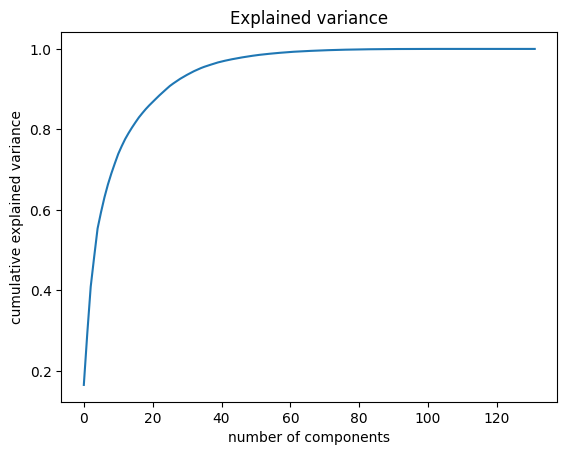

In [13]:
# perform PCA on X_tr
pca = PCA().fit(X_tr)

variance = pca.explained_variance_ratio_
n_var = 300
variance_90 = variance[0:n_var]
ratio = sum(variance_90)/sum(variance)
print(n_var, 'largest principal components explain for', round(ratio*100,2), '% of variance.')

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Explained variance')

In [14]:
data_pca = PCA(n_components=30).fit(X_tr)
print(data_pca)

X_tr_pca = data_pca.transform(X_tr)
X_tst_pca = data_pca.transform(X_tst)

PCA(n_components=30)


In [15]:
def plot_cluster(pca_feature, label):
    with plt.style.context(("seaborn", "ggplot")):
        fig,ax = plt.subplots(1, figsize=(10, 6))
        points = ax.scatter(pca_feature[:,0],pca_feature[:,1], c=label, s=20, cmap='plasma')
        fig.colorbar(points)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.title('Visualizing the classes with PCA')
        plt.show()

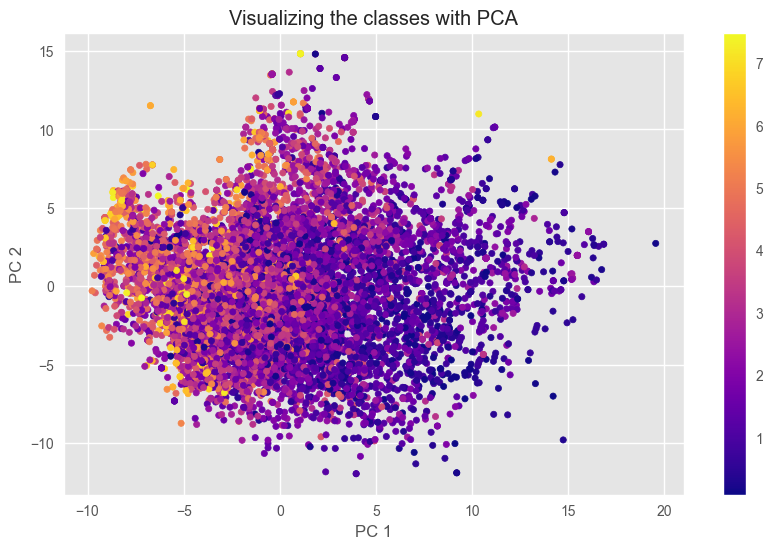

In [16]:
plot_cluster(X_tr_pca, Y_tr)

### 3. Randomize and model selection

In [17]:
# split the dataset to train and validation (Train:Val = 75:25)
x_train, x_val, y_tr, y_val = train_test_split(X_tr, Y_tr, test_size=0.25, random_state=42)

#### 3.2 Linear Model Selection

In [18]:
models = {}
# Lasso Regression
from sklearn.linear_model import Lasso
models['Lasso Regression'] = Lasso(alpha=0.1)

# Ridge Regression
from sklearn.linear_model import Ridge
models['Ridge Regression'] = Ridge(alpha = 0.1)

# Linear Regression
from sklearn.linear_model import LinearRegression
models['Linear Regression'] = LinearRegression(normalize=True)

# ElasticNet
from sklearn.linear_model import ElasticNet
models['ElasticNet'] = ElasticNet(alpha=0.1, l1_ratio=0.6)

from sklearn.ensemble import GradientBoostingRegressor
models['GradientBoosting'] = GradientBoostingRegressor()

from sklearn.linear_model import SGDRegressor
models['SGDRegressor'] = SGDRegressor()

from xgboost.sklearn import XGBRegressor
models['XGBRegressor'] = XGBRegressor()

from lightgbm import LGBMRegressor
models['LGBMRegressor'] = LGBMRegressor()

In [19]:
from sklearn.metrics import mean_absolute_error as MAE

mean_abs_err = {}
for key in models.keys():
    # Fit the classifier
    models[key].fit(x_train, y_tr)
    # Make predictions
    predictions = models[key].predict(x_val)
    print(predictions)
    # Calculate metrics
    mean_abs_err[key] = MAE(predictions, y_val)

[3.50891895 2.43426477 2.73051468 ... 2.3375107  1.68262668 2.01173606]
[3.63949952 2.50382116 1.91578342 ... 2.1268408  1.18528799 1.8291138 ]
[3.52513564 2.52318251 1.84459364 ... 2.06932509 1.18260634 1.83720839]
[3.65180679 2.52816058 2.75833239 ... 2.2238848  1.66590416 1.95593913]
[3.48446685 2.16788316 2.17095917 ... 1.67755183 1.55973057 2.09843862]
[ -141.27119777  1249.92457597 -1127.4476404  ...   226.61248237
 -1036.18470335   637.23722093]
[2.8136437 1.902758  2.7731638 ... 1.9504341 1.2517072 2.558769 ]
[3.48213361 1.91453887 2.50322912 ... 1.58907687 1.24851988 2.45079143]


In [20]:
df_model = pd.DataFrame(index=models.keys(), columns=['Mean Absolute Error'])
df_model['Mean Absolute Error'] = mean_abs_err.values()

df_model

,Mean Absolute Error
Lasso Regression,0.920043
Ridge Regression,0.835347
Linear Regression,0.836569
ElasticNet,0.895796
GradientBoosting,0.706905
SGDRegressor,745.526353
XGBRegressor,0.586057
LGBMRegressor,0.588725


### 4. Best model optimization

#### 4.1 Tuning Parameters for Gradient Boosting Regression

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
# models['GradientBoosting'] = GradientBoostingRegressor()

# loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, 
# criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
# max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, 
# verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001

param_grid_lr = {                      
    'loss': ['huber'],
    'learning_rate': [1, 0.50, 0.10],
    'criterion': ['squared_error'],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 8, 11]
}

clf_grid = GridSearchCV(estimator=GradientBoostingRegressor(random_state=128), 
                             param_grid=param_grid_lr,
                             verbose=3, 
                             scoring = 'neg_mean_absolute_error',
                             cv=5, 
                             n_jobs=-1,
                             return_train_score=True)
best_lr = clf_grid.fit(X_tr, Y_tr)
print(best_lr.best_params_)
print(best_lr.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 8, 'n_estimators': 500}
-0.5323832027075829


In [23]:
result = pd.DataFrame(clf_grid.cv_results_)
result_highlighted = result[['params','mean_test_score','rank_test_score', 'mean_fit_time']]
result_highlighted = result_highlighted.sort_values(['rank_test_score'], ascending=True)
result_highlighted.head(20)

,params,mean_test_score,rank_test_score,mean_fit_time
32,"{'criterion': 'squared_error', 'learning_rate'...",-0.532383,1,471.950243
31,"{'criterion': 'squared_error', 'learning_rate'...",-0.535659,2,187.178101
29,"{'criterion': 'squared_error', 'learning_rate'...",-0.538050,3,307.423036
34,"{'criterion': 'squared_error', 'learning_rate'...",-0.545355,4,305.247938
35,"{'criterion': 'squared_error', 'learning_rate'...",-0.545635,5,548.443718
33,"{'criterion': 'squared_error', 'learning_rate'...",-0.545956,6,158.603173
30,"{'criterion': 'squared_error', 'learning_rate'...",-0.546106,7,109.460257
28,"{'criterion': 'squared_error', 'learning_rate'...",-0.567447,8,126.480554
14,"{'criterion': 'squared_error', 'learning_rate'...",-0.587925,9,167.026407
26,"{'criterion': 'squared_error', 'learning_rate'...",-0.595609,10,179.589343


In [24]:
lr_model = GradientBoostingRegressor(random_state=128, criterion='squared_error', learning_rate = 0.1, 
                                     loss = 'huber', max_depth = 8, n_estimators = 500)
grb = lr_model.fit(X_tr, Y_tr)

In [25]:
y_test = grb.predict(X_tst)

In [26]:
y_test_df = pd.DataFrame(list(ID_test), columns = ['Id'])
y_test_df['Egap'] = list(y_test)
y_test_df.head()

,Id,Egap
0,13062,3.023373
1,587,2.770861
2,2333,3.185505
3,7740,5.077554
4,9463,1.715725


In [27]:
# save to .csv file
y_test_df.to_csv('y_test.csv',index=False)
# mean absolute error = 0.57431 on Kaggle public test set

#### 4.2 Tuning parameters for XGBoost Regression Model

In [37]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.05, 0.1],
           'n_estimators': [500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = XGBRegressor(seed = 128)
clf_grid = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1)
best_lr = clf_grid.fit(X_tr, Y_tr)
print(best_lr.best_params_)
print(best_lr.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}
-0.5299287979641674


In [38]:
result = pd.DataFrame(clf_grid.cv_results_)
result_highlighted = result[['params','mean_test_score','rank_test_score', 'mean_fit_time']]
result_highlighted = result_highlighted.sort_values(['rank_test_score'], ascending=True)
result_highlighted.head(20)

,params,mean_test_score,rank_test_score,mean_fit_time
21,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",-0.529929,1,34.389548
5,"{'colsample_bytree': 0.3, 'learning_rate': 0.0...",-0.530395,2,33.522838
3,"{'colsample_bytree': 0.3, 'learning_rate': 0.0...",-0.530511,3,20.577918
4,"{'colsample_bytree': 0.3, 'learning_rate': 0.0...",-0.531213,4,18.181921
9,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-0.531811,5,18.539764
15,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-0.532539,6,31.375594
17,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-0.533414,7,60.035097
16,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-0.534402,8,31.647199
11,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-0.536416,9,30.123167
20,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",-0.536436,10,15.999757


In [32]:
# best model
lr_model = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.1, max_depth = 6, n_estimators = 1000)
xgb = lr_model.fit(X_tr, Y_tr)

In [33]:
# Predict y_test using X_test
y_test = xgb.predict(X_tst)

In [34]:
y_test_df = pd.DataFrame(list(ID_test), columns = ['Id'])
y_test_df['Egap'] = list(y_test)
y_test_df.head()

,Id,Egap
0,13062,3.131656
1,587,2.486704
2,2333,2.649853
3,7740,5.203563
4,9463,1.658845


In [35]:
# save to .csv file
y_test_df.to_csv('y_test.csv',index=False)
# mean absolute error = 0.47461 on Kaggle public test set

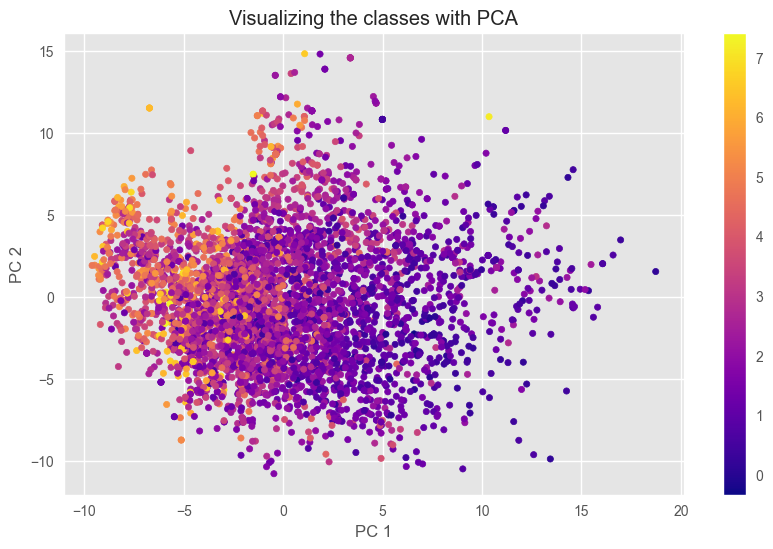

In [36]:
plot_cluster(X_tst_pca, y_test)